# Lab for Week 8: Naive Bayes and Bayesian Logistic Regression

This week, we are going to first explore the Naive Bayes classifier -- first for categorical and then for real-valued data (assumed to be distributed by Gaussians). We are then also going to explore the two different techniques of Bayesian classification -- first with fitting a variational to the mode of the point estimate (Laplace approximation), and the second by starting a random walk (with rejection sampling) from the point estimate (MH Sampling).

Again, these functionalities are provided in the scikit library. However, we'll build them from the first principles for learning purposes.

So, the aims for this week's lab are:

- #### Aims:
    - Revise Week 8 lecture notes
    - Understand/Implement a Naive Bayes classifier for categorical data (text classification)
    - Understand/Implement a Naive Bayes classifier for real-valued data
    - Understand/Implement a Bayesian classifier with Laplace Approximation 
    - Understand/Implement a Bayesian classifier with MH sampling
    

## Task 1:  Implement a Naive Bayes classifier for Text Classification

In the lecture notes, we had worked out a numerical example on categorical data. Now we will write a Python implementation for this.

We're going to work with the two files, namely `cheeseDisease.train` and `cheeseDisease.test`, for this text classification task included in the folder for this week's lab. In each file, the first column indicates a class label, which is either a cheese name (`1`) or a disease name (`2`). For example, the training data looks like:

2	Back Pain
2	Dissociative Disorders
2	Lipoma
1	Blue Rathgore
2	Gallstones
1	Chevrotin des Aravis
2	Pulmonary Embolism
2	Gastroenteritis
2	Ornithine Carbamoyltransferase Deficiency Disease
2	Eisenmenger Complex

The first step is to define a vocabulary, i.e., the set of all possible expected feature values. Instead of working with `words`, here we are going to work with `character 3 grams`, which is a sequence of 3 consecutive characters, e.g., the character-3 grams of `Bayes` are: `Bay`, `aye`, and `yes`.

We define the following Python function to perform this job.

In [1]:
def extract_trigrams(text):
    """
    Extract character-level tri-grams from a string.
    E.g., "cheese" -> ["che", "hee", "ees", "ese"]
    """
    text = text.strip()
    if len(text) < 3:
        return []  # No trigrams possible
    return [text[i:i+3] for i in range(len(text) - 2)]


We then need to write the code to load the two datasets: train and test as lists of labels and strings. We will then call `extract_trigrams` on each text instance to convert them to trigram features. Here's the code for that purpose.

In [2]:
import numpy as np
from collections import defaultdict, Counter
import math

def load_data(path):
    """
    Reads a tab-separated dataset with columns:
        label<TAB>string
    Returns:
        labels: list[int]
        texts: list[str]
    """
    labels = []
    texts = []
    with open(path, "r") as f:
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) != 2:
                continue
            label = int(parts[0])
            text = parts[1]
            labels.append(label)
            texts.append(text.lower())
    return labels, texts

Once we load the data, we now extract trigrams, which in the process, also builds the vocabulary (the set of all trigrams seen in the entire training set).

In [3]:
def build_vocabulary(texts):
    """
    Construct a vocabulary of all tri-grams appearing in the dataset.
    Returns:
        vocab: sorted list of trigram strings
    """
    vocab = set()
    for txt in texts:
        for tri in extract_trigrams(txt):
            vocab.add(tri)
    return sorted(vocab)

We now need to write a NaiveBayes classifier which during training should compute the class specific trigram statistics, i.e., we compute $P(x|y)$, where $x$ is a trigram feature and $y$ is a class.

### TASK 1.1: Complete the code for the training

Specfically, for $P(x|y)$, we maintain the dictionary `trigram_likelihoods` to store the frequency of each trigram for each class. We also need to compute the class priors (i.e., $P(y)$, which is maintained in `class_total_counts`). Insert code to ensure that correct values are stored in these data structures.

Use Laplace smoothing (see lecture notes) for estimating these probabilities.


In [4]:
############################################################
# Naive Bayes Model (to be completed by students)
############################################################

class NaiveBayesTrigram:
    def __init__(self):
        self.classes = None
        self.vocab = None
        self.class_priors = {}         # P(y)
        self.trigram_likelihoods = {}  # P(x=trigram | y)
        self.class_trigram_counts = {} # raw counts for explanation/debugging
        self.class_total_counts = {}   # total trigram count per class

    def fit(self, labels, texts):
        """
        Train Naive Bayes classifier on categorical string data using tri-grams.
        You must complete: computing P(y) and P(trigram | y).
        """
        self.classes = sorted(set(labels))

        # Build vocabulary from ALL training data
        self.vocab = build_vocabulary(texts)

        # Initialize raw count structures
        self.class_trigram_counts = {c: Counter() for c in self.classes}
        self.class_total_counts = {c: 0 for c in self.classes}
        class_counts = Counter(labels)

        ############################################################
        # STEP 1: Compute class priors P(y)
        # Students should understand why dividing by total samples
        ############################################################
        total_samples = len(labels)
        for c in self.classes:
            # ---> IMPLEMENT THIS <---
            # self.class_priors[c] = ...
            self.class_priors[c] = class_counts[c] / total_samples

        ############################################################
        # STEP 2: Count tri-grams per class
        ############################################################
        for label, txt in zip(labels, texts):
            tri_list = extract_trigrams(txt)
            self.class_trigram_counts[label].update(tri_list)
            self.class_total_counts[label] += len(tri_list)

        ############################################################
        # STEP 3: Estimate likelihoods P(trigram | y)
        # Use Laplace smoothing:
        #   (count + 1) / (total_count + |V|)
        ############################################################
        V = len(self.vocab)
        for c in self.classes:
            self.trigram_likelihoods[c] = {}
            for tri in self.vocab:
                count = self.class_trigram_counts[c][tri]
                total = self.class_total_counts[c]
                # ---> STUDENTS SHOULD IMPLEMENT THIS <---
                # self.trigram_likelihoods[c][tri] = ...
                self.trigram_likelihoods[c][tri] = (count + 1) / (total + V)

### TASK 1.2: Write the code for computing the posteriors at inference time

Given a text (a cheese or a disease name) you now need to compute the posteriors for the two classes and assign the instance to the more likely one. Recall that the first step is to decompose a text instance into independent features, which in our problem setting are **trigrams**.

$$ P(y=k| \mathbf{x}) = \prod_{i} P(y=k|x_i) = \frac{1}{Z} P(x_i|y=k)P(y=k)$$

Here, each $x_i$ is a trigram of the observed data point, $P(x_i|y=k)$ and $P(y=k)$ are respectively obtained from the training set stats (`trigram_likelihoods` and `class_priors`), and $Z$ is the normalisation constant (*do you need it?*)

Now complete the implementation of the following function.

In [5]:
########################################################################
# Prediction (inference)
########################################################################

def predict_log_posteriors(nb_model, text):
    """
    Compute log posterior log P(y | x) for all classes.
    Uses:
        log P(y) + sum(log P(trigram | y))
    """
    tri_list = extract_trigrams(text)
    log_post = {}

    for c in nb_model.classes:
        log_p = math.log(nb_model.class_priors[c])

        for tri in tri_list:
            if tri in nb_model.vocab:
                log_p += math.log(nb_model.trigram_likelihoods[c][tri])
            else:
                # unseen trigram -> uniform small penalty
                log_p += math.log(1e-9)

        log_post[c] = log_p

    return log_post

In [6]:
def predict(nb_model, text):
    """
    Return class with highest posterior probability.
    """
    log_post = predict_log_posteriors(nb_model, text)
    return max(log_post, key=log_post.get)


def evaluate(model, labels, texts):
    correct = 0
    for y, txt in zip(labels, texts):
        y_pred = predict(model, txt)        
        if y_pred == y:
            correct += 1
    return correct / len(labels)

Once you have completed the code, you should be able to run the classifier and evaluate its performance.

### OPTIONAL ADDITIONAL TASK:
What are the hyper-parameters? How can you control the behaviour of the classifier?

In [7]:
train_labels, train_texts = load_data("cheeseDisease.train")
model = NaiveBayesTrigram()
model.fit(train_labels, train_texts)


test_labels, test_texts = load_data("cheeseDisease.test")
accuracy = evaluate(model, test_labels, test_texts)
print("Accuracy: {:.4f}".format(accuracy))

Accuracy: 0.8929


## Task 2:  Implement a Naive Bayes classifier for real-valued features

Recall from the lecture notes that NB can also be applied to real-valued data, where we simply assume that data points are generated from a Gaussian distribution with no cross-correlation components (i.e., we just work with $d$ **univariate Gaussians** where $d$ is the dimension of the data).

For this task, similar to previous weeks, we are going to use the sample two dimensional data (also attached in the zipped folder for this week's lab).

In [8]:
traindata = np.loadtxt('trainx.csv',delimiter=',')
testdata = np.loadtxt('testx.csv',delimiter=',')
trainX = traindata[:,:2] # X, training data 
traint = traindata[:,2]  # t, training label
testX = testdata[:,:2]   # X_test, 
testt = testdata[:,2]    # t_test

Text(0, 0.5, 'Feature 2')

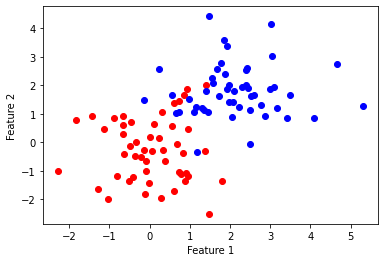

In [9]:
import pylab as plt
%matplotlib inline

plt.plot(trainX[:50,0],trainX[:50,1],'ro') 
plt.plot(trainX[50:,0],trainX[50:,1],'bo')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

### Task 2.1: Write your function to estimate the parameters of the Gaussians for Naive Bayes (one Gaussian for each class)

We will use Gaussian distributions for each class. For each class, we fit a Gaussian to each dimension (by compute the mean and variance). The prior for each class will be the proportion of training data in that class. Here's the function.

In [10]:
def naive_bayes_training(trainX, traint):
    parameters = {}
    for cl in range(2):
        data_pos = np.where(traint==cl)[0]
        class_pars = {}
        class_pars['mean'] = trainX[data_pos,:].mean(axis=0)
        class_pars['vars'] = trainX[data_pos,:].var(axis=0)
        class_pars['prior'] = 1.0*len(data_pos)/len(trainX)
        parameters[cl] = class_pars
    return(parameters)

parameters = naive_bayes_training(trainX, traint)

### Task 2.2: Write your function to make prediction on testX with the trained Gaussian Naive Bayes classifier 

Computing the likelihood for each class and multiplying by the prior, and normalise. Make sure you function also returns the probability of assigning the test data to each class.

In [11]:
def naive_bayes_prediction(parameters, testX):
    un_norm_prob = np.zeros((2,))
    for cl in parameters:
        un_norm_prob[cl] = parameters[cl]['prior']
        for i,m in enumerate(parameters[cl]['mean']):
            vari = parameters[cl]['vars'][i]
            un_norm_prob[cl] *= 1.0/np.sqrt(2.0*np.pi*vari)
            un_norm_prob[cl] *= np.exp((-0.5/vari)*(tx[i]-m)**2)
    norm_prob = un_norm_prob/un_norm_prob.sum()
    prediction = {}
    prediction['predicted_class'] = norm_prob.argmax()
    prediction['predicted_score'] = norm_prob
    return(prediction) 

Once you're done implementing the two above functions, you should now be able to run the classifier and evaluate its peformance.

In [12]:
predictions_nb = np.zeros((400, 3))
for j,tx in enumerate(testX):
    naive_bayes_results = naive_bayes_prediction(parameters, tx)
    predictions_nb[j, 0] = naive_bayes_results['predicted_class']
    predictions_nb[j, 1:] = naive_bayes_results['predicted_score']
    
accuracy = (predictions_nb[:,0] == testt).mean()
print (accuracy)

0.89


## Task 3: Laplace approximation

### Task 3.0.1: First, let's define the sigmoid and its gradient (you already had done this in Week 6's lab)

Instead of the solution for Week 6, this week we are now going to use scipy's optimizer (make sure to check the equivalence with the solution of Week 6 lab).

Augment the value of "1" as an additional dimension to facilitate inner-products.

$$ \mathbf{x}_n = \begin{bmatrix} x_{n,1} \\ x_{n,2} \\ 1 \end{bmatrix} $$

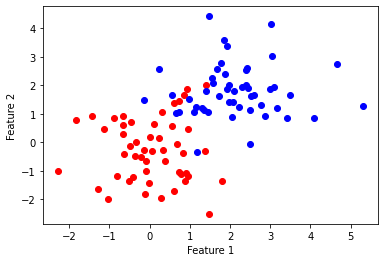

In [13]:
traindata = np.loadtxt('trainx.csv',delimiter=',')
trainx = traindata[:,:2] # X, training data 
traint = traindata[:,2][:,None]  # t, training label, make it a column vector

plt.figure()
plt.plot(trainx[:50,0],trainx[:50,1],'ro') # plot the data
plt.plot(trainx[50:,0],trainx[50:,1],'bo')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

trainX = np.hstack((trainx, np.ones_like(traint)))

In [14]:
def sigmoid(x): # sigmoid function 
    return(1.0 / (1.0 + np.exp(-x)))

def BLR_objective(w, t, X, s): # The negative objective function for Bayesian logistic regression
    w = w[:,None]
    ss = sigmoid( np.dot( X, w) )
    l = np.sum( - w*w/(2.0*s) )  + np.sum(t*np.log(ss) + (1-t)* np.log(1-ss) ) 
    return(-l)

def BLR_gradient(w, t, X, s): # The gradient of the negative objective function for Bayesian logistic regression
    w = w[:,None]
    ss = sigmoid( np.dot( X, w) )
    g = -w/s + np.dot( X.T, t - ss )
    return(-g[:,0])


### Task 3.0.2: Test your objective and gradient before using the minimizer 

In [15]:
s = 1 # set s^2 = 1 
w0 = np.ones((trainX.shape[1], )) # make sure w0's shape is (d,)
eps    = 1e-4 # step size 
mygrad = BLR_gradient(w0, traint, trainX, s)
fdgrad = np.zeros(w0.shape)
for d in range(len(w0)): # pertub each dimension in term
    mask = np.zeros(w0.shape) # a binary mask that only allows selected dimension to change
    mask[d]   = 1
    fdgrad[d] = (BLR_objective(w0 + eps*mask, traint, trainX, s) - 
                 BLR_objective(w0 - eps*mask, traint, trainX, s))/(2*eps) # definition of gradient

print("MYGRAD: ", mygrad) # my gradient output
print("FDGRAD: ", fdgrad) # numerical gradient
print("Error: ", np.linalg.norm(mygrad-fdgrad)/np.linalg.norm(mygrad+fdgrad) ) # error 

MYGRAD:  [ 7.42532166  0.85610828 31.98456474]
FDGRAD:  [ 7.42532165  0.85610827 31.98456474]
Error:  2.1128010225986064e-10


### Task 3.0.3: Use `scipy`'s `minimize` to estimate $\mathbf{w}_{MAP}$ 

$$\mathbf{w}_{MAP} = \underset{\mathbf{w}}{\operatorname{argmax}} \log g(\mathbf{w}; \mathbf{t}, \mathbf{X}, s^2)$$

In [16]:
import scipy.optimize as opt
w0 = np.zeros((trainX.shape[1],)) # set starting point
res = opt.minimize(BLR_objective, w0, args=(traint, trainX, s), method='BFGS', 
                   jac=BLR_gradient, options={'gtol': 1e-7, 'disp': True})
w_map = res.x [:,None] 
print("MAP solution: ", w_map)

Optimization terminated successfully.
         Current function value: 24.135640
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
MAP solution:  [[ 1.44883475]
 [ 1.16575571]
 [-2.15198994]]


### Task 3.0.4: Plot the decision boundaries (we had done all of this in the lab of Week 6)

In [17]:
def BLR_prediction_map(w, x): # prediction with MAP solution
    return( sigmoid( np.dot(w.T, x) ) )

xvals = np.arange(-3,6,0.1)
Ngrid = len(xvals)
gridpred = np.zeros((Ngrid,Ngrid))
for i in range(len(xvals)):
    for j in range(len(xvals)):
        pp = np.hstack((xvals[i],xvals[j], 1))[:,None]
        gridpred[i][j] = BLR_prediction_map(w_map, pp)

<a list of 6 text.Text objects>

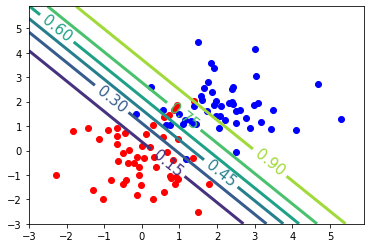

In [18]:
plt.figure()
pos0 = np.where(traint==0)[0]
pos1 = np.where(traint==1)[0]
plt.plot(trainx[pos0,0],trainx[pos0,1],'ro')
plt.plot(trainx[pos1,0],trainx[pos1,1],'bo')
A = plt.contour(xvals,xvals,gridpred.T,linewidths=3)
plt.clabel(A, inline=1, fontsize=15)

With Laplace approximation we approximate the posterior distribution by a Gaussian distribution: 
$$p(\mathbf{w} | \mathbf{t}, \mathbf{X}, s) \approx \mathcal{N} (\boldsymbol \mu, \boldsymbol \Sigma) $$
where $$\boldsymbol \mu = \mathbf{w}_{MAP}, \quad \boldsymbol \Sigma^{-1} = \left. -\frac{\partial^2 \log g(\mathbf{w}; \mathbf{t}, \mathbf{X}, s^2) } {\partial \mathbf{w} \partial \mathbf{w}^T} \right|_{\mathbf{w} = \mathbf{w}_{MAP}} = -\frac{1}{s^2}\mathbf{I} - \mathbf{X}^T d \boldsymbol \sigma \mathbf{X}$$
where $d \boldsymbol \sigma$ is a diagonal matrix with elements on the diagonal equals to the following
$$\mbox{diag}( d \boldsymbol \sigma ) = 
    \left[ \sigma(\mathbf{w}_{MAP}^T \mathbf{x}_1) (1- \sigma(\mathbf{w}_{MAP}^T \mathbf{x}_1) ), 
     \sigma(\mathbf{w}_{MAP}^T \mathbf{x}_2)(1- \sigma(\mathbf{w}_{MAP}^T \mathbf{x}_2) ),
    \dots,
     \sigma(\mathbf{w}_{MAP}^T \mathbf{x}_N) (1- \sigma(\mathbf{w}_{MAP}^T \mathbf{x}_N) )
     \right]$$
     
User `numpy`'s `diag` function
https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.diag.html

### Task 3.1: Compute the mean and covariance matrix of $\mathcal{N} (\boldsymbol \mu, \boldsymbol \Sigma)$

In [19]:
lap_mean = w_map

def compute_lap_cov(w, X, s): # your function to compute the covariance matrix of the Gaussian distribution in Laplace approximation
    w = w[:,0]
    ss = sigmoid(np.dot(X, w))
    ds = np.diag( ss * (1-ss) )
    return( np.linalg.inv( 1/s * np.eye(X.shape[1]) + np.dot(np.dot(X.T, ds), X) )) 

lap_cov =  compute_lap_cov(w_map, trainX, s)

print(lap_cov)

[[ 0.13501075 -0.02320111 -0.09023716]
 [-0.02320111  0.09957826 -0.04752084]
 [-0.09023716 -0.04752084  0.20773268]]


### Task 3.2: Generate lots of samples from $\mathcal{N} (\boldsymbol \mu, \boldsymbol \Sigma)$

In [20]:
np.random.seed(1)
n_samps = 1000
w_samps = np.random.multivariate_normal(lap_mean.flatten(),lap_cov,n_samps)
w_samps.shape

(1000, 3)

(-3.0, 6.0)

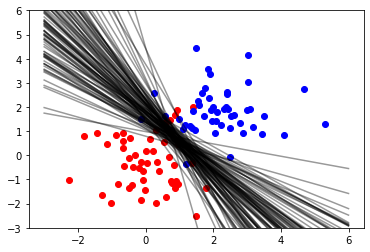

In [21]:
plt.figure()
pos0 = np.where(traint==0)[0]
pos1 = np.where(traint==1)[0]
plt.plot(trainx[pos0,0],trainx[pos0,1],'ro')
plt.plot(trainx[pos1,0],trainx[pos1,1],'bo')
xlims = np.array([-3,6])
for i in range(100):
    this_w = w_samps[i,:]
    ylims = (- this_w[2]- this_w[0]*xlims)/this_w[1] # Decision boundry at w^T*x = 0
    plt.plot(xlims,ylims,'k',alpha=0.4)
    
plt.ylim((-3,6)) 

### Task 3.3:  Average over them to create the contours

In [22]:
def BLR_prediction_lap(w_samps, x): # prediction with samples from the Laplace approximation
    return( sigmoid( np.dot(w_samps, x) ).mean() )

gridpred = np.zeros((Ngrid,Ngrid))
for i in range(len(xvals)):
    for j in range(len(xvals)):
        pp = np.hstack((xvals[i],xvals[j],1))[:,None]
        gridpred[i][j] = BLR_prediction_lap(w_samps, pp)

<a list of 6 text.Text objects>

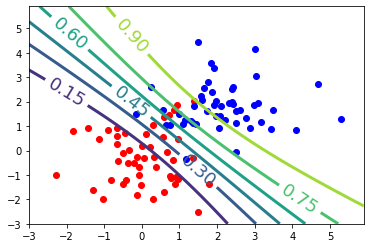

In [23]:
plt.figure()
pos0 = np.where(traint==0)[0]
pos1 = np.where(traint==1)[0]
plt.plot(trainx[pos0,0],trainx[pos0,1],'ro')
plt.plot(trainx[pos1,0],trainx[pos1,1],'bo')
A = plt.contour(xvals,xvals,gridpred.T,linewidths=3)
plt.clabel(A, inline=1, fontsize=18)

## Task 4: Metropolis-Hastings sampling for Bayesian Classification

### Task 4.1: Implement the MH algorithm

In [24]:
np.random.seed(1)

w = np.zeros_like(w_map) # starting point
n_samps = 10000 # number of samples
w_samps = np.zeros((n_samps,w.shape[0])) # preallocate samples
old_like = -BLR_objective (w.flatten(), traint, trainX, s) # This time the orginal objective function not the negative one

for i in range(n_samps):    
    
    # Propose a sample
    w_new = w + np.random.normal(0, 1, (w.shape)) # add standard normally distributed noise to w
    new_like = - BLR_objective (w_new.flatten(), traint, trainX, s) # compute the orginal objective at w_new 
    
    # Accept/Reject proposed sample
    if np.random.rand() <= np.exp(new_like - old_like): 
        w = w_new
        old_like = new_like
    w_samps[i,:] = w.T

### Task 4.2: Plot some of the sampled decision boundaries

(-3.0, 6.0)

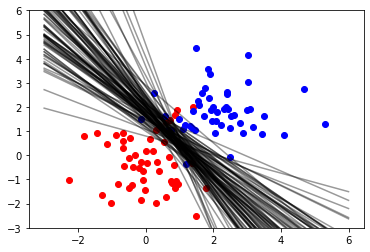

In [25]:
plt.figure()
pos0 = np.where(traint==0)[0]
pos1 = np.where(traint==1)[0]
plt.plot(trainx[pos0,0],trainx[pos0,1],'ro')
plt.plot(trainx[pos1,0],trainx[pos1,1],'bo')
xlims = np.array([-3,6])
for i in range(100):
    this_w = w_samps[2+np.random.randint(n_samps),:]
    ylims = (- this_w[2]- this_w[0]*xlims)/this_w[1] # Decision boundry at w^T*x = 0
    plt.plot(xlims,ylims,'k',alpha=0.4)
    
plt.ylim((-3,6))
    

### Task 4.3:  Average over them to create the contours

In [26]:
def BLR_prediction_mh(w_samps, x): # The function should be the same with prediction with Laplace approximation
    return( sigmoid( np.dot(w_samps, x) ).mean() )

gridpred = np.zeros((Ngrid,Ngrid))
for i in range(len(xvals)):
    for j in range(len(xvals)):
        pp = np.hstack((xvals[i],xvals[j],1))[:,None]
        gridpred[i][j] = BLR_prediction_mh(w_samps, pp)

<a list of 6 text.Text objects>

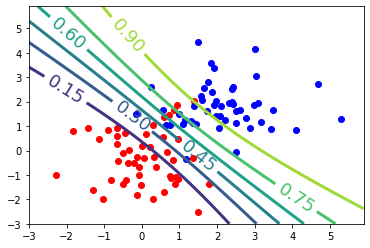

In [27]:
plt.figure()
pos0 = np.where(traint==0)[0]
pos1 = np.where(traint==1)[0]
plt.plot(trainx[pos0,0],trainx[pos0,1],'ro')
plt.plot(trainx[pos1,0],trainx[pos1,1],'bo')
A = plt.contour(xvals,xvals,gridpred.T,linewidths=3)
plt.clabel(A, inline=1, fontsize=18)